<a href="https://colab.research.google.com/github/courtneytumolac/Data-Science/blob/main/CourTumoU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

  Using cached preliz-0.16.0-py3-none-any.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 6.8 MB/s eta 0:00:00


For my project, I decided to use this data on all time goalscorers for the National Football League in Japan (which is soccer). I was curious to see which variables contributed to the amount of goals a player makes. Here I'm just viewing the actual data itself. For some reason, in certain columns there was an apostrophe after the values which meant that they were strings instead of floats. They needed to be floats for the BART analysis (or it wouldn't work), so I had to fix that part first.

In [52]:
soccer = pd.read_csv('https://raw.githubusercontent.com/courtneytumolac/Data-Science/refs/heads/main/japan_soccer.csv')

In [53]:
# Removing the apostrophe at the end of the values
# I didn't do minutes per goal because i didn't think of using that for the BART model
soccer['Minutes played'] = soccer['Minutes played'].str.replace("'", "").astype(float)

In [36]:
soccer.head()

,Number,Player,Position,Age (today),Appearances,Assists,Penalty kicks,Minutes played,Minutes per goal,Goals per match,Goals
0,1,Masatoshi Matsuda,Centre-Forward,33 (44),171,27,12,13.318,157',0.50,85
1,2,Yuta Uchino,Centre-Forward,30 (33),217,26,1,13.463,184',0.34,73
2,3,Gen Nakamura,Attacking Midfield,36 (44),244,50,18,20.084,283',0.29,71
3,4,Koji Ishihara,Centre-Forward,32,258,33,10,19.243,271',0.28,71
4,5,Jun Arima,Centre-Forward,27 (32),133,15,13,10.468,156',0.50,67


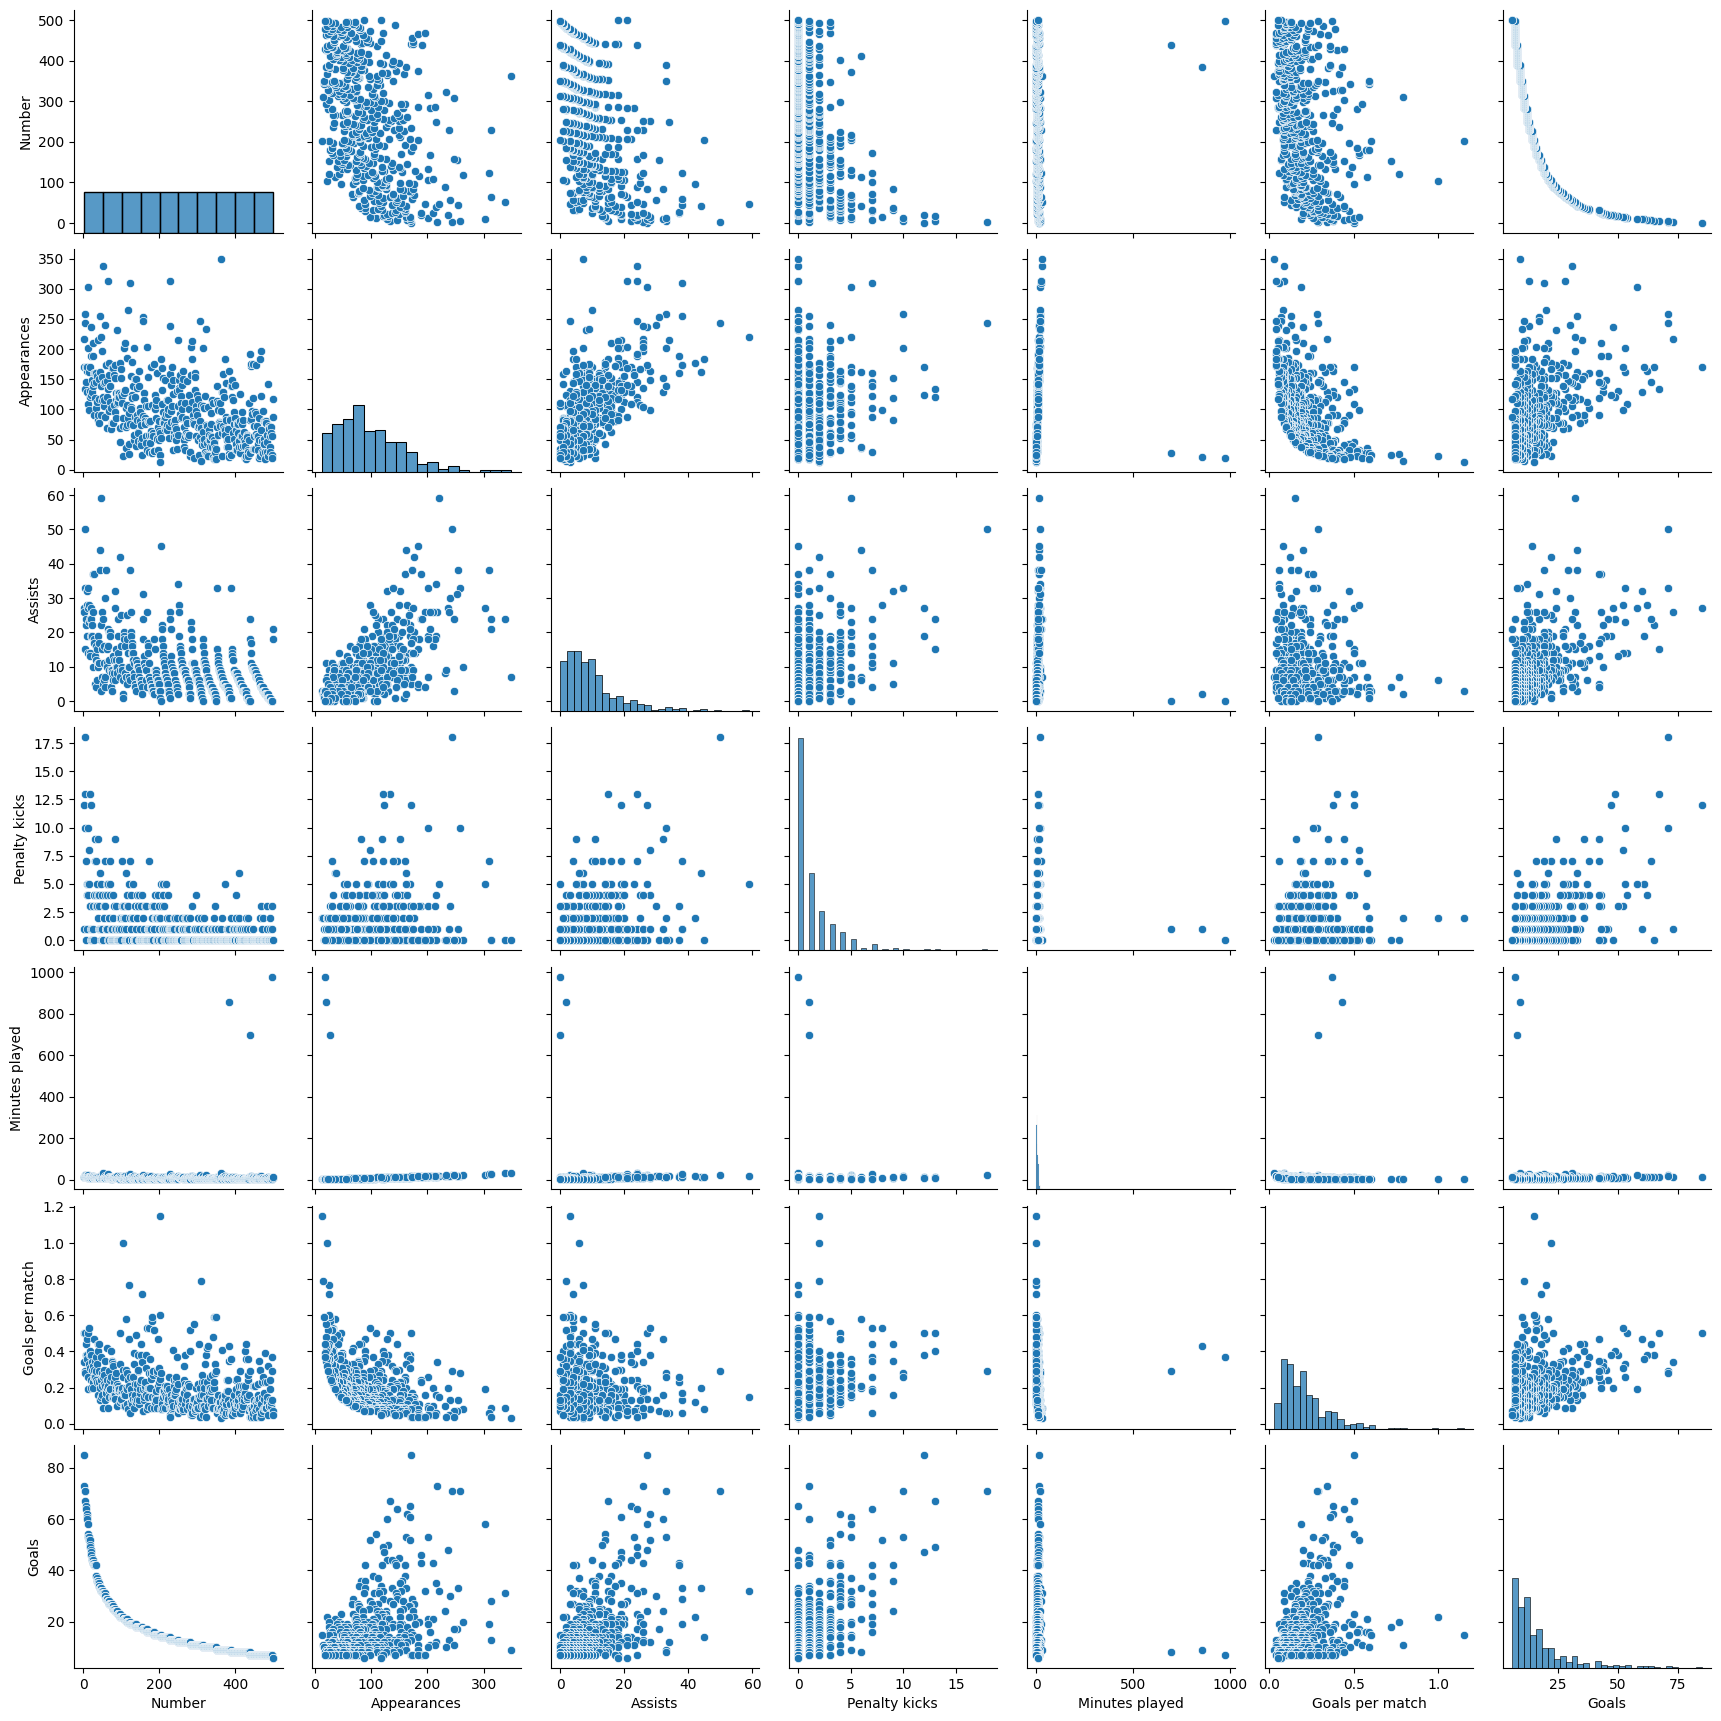

In [54]:
# just looking at interactions between the variables
df = pd.DataFrame(soccer)
sns.pairplot(df)

I honestly didn't really look at the seaborn plots I just made, because I don't really understand it, but I thought it looked cool so I kept it here. I decided to use appearances, minutes played, and goals per match as my predictors. Appearances and minutes played are directly related to how much a player is actually on the field, and it seems intuitive that the more a player is on the field, the more chances they have to score goals. These are all-time goalscorers across all seasons, so even if they simultaneously have more chances to fumble too, it doesn't seem very likely to me. Goals per match is also pretty intuitive, if you score more goals per match, then you will also score more goals overall.

To be honest, I was thinking of using penalty kicks, because scoring penalty kicks does count as a goal. However, I decided against it because it would also include penalty kicks that weren't scored. That being said, having more penalty kicks can be correlated to being a better player because your team chooses you to make the kick over others. So maybe I will analyze this in the future.

Minutes played has some level of interaction with apperances, because appearances just refers to the games a player has played in, even if it was just for one minute. Minutes played will actually tell you if the player was playing full matches, but more minutes played will obviously equal more appearances since you can't have one without the other.

In [60]:
#X is our predictor variables
X = soccer[["Appearances", "Minutes played", "Goals per match"]].to_numpy()
#Y is the predicted variable, goals
Y = soccer["Goals"].to_numpy()

Here I was just looking at the shape and trying to think of a likelihood, and it kind of looks like Gamma so that's just what I went for.

(array([273., 122.,  47.,  24.,  13.,   9.,   4.,   4.,   3.,   1.]),
 array([ 6. , 13.9, 21.8, 29.7, 37.6, 45.5, 53.4, 61.3, 69.2, 77.1, 85. ]),
 <BarContainer object of 10 artists>)

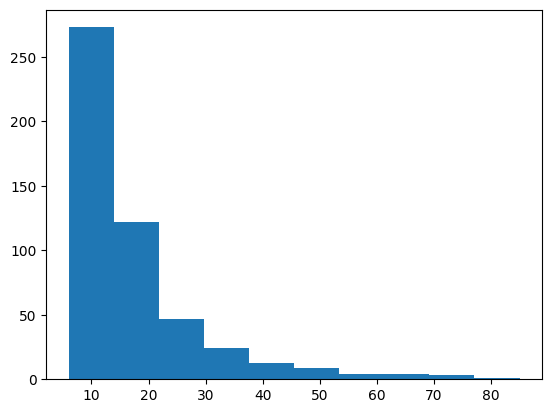

In [39]:
plt.hist(soccer.Goals)

<Axes: >

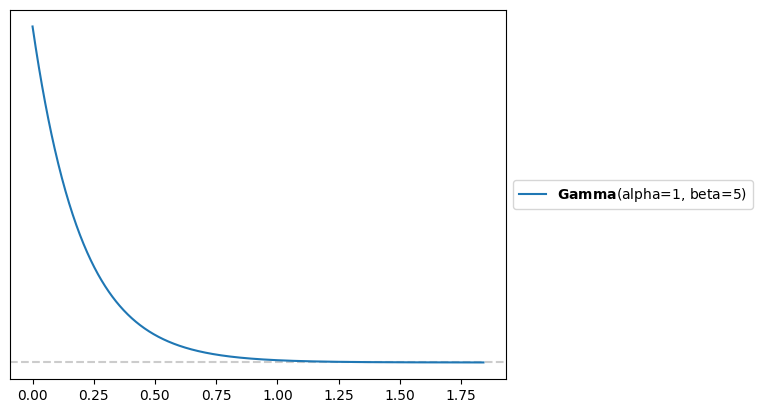

In [55]:
pz.Gamma(1,5).plot_pdf()

In [63]:
#I don't exactly know what the numbers mean so I just kept them the same
with pm.Model() as model_soccer:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_soccer = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

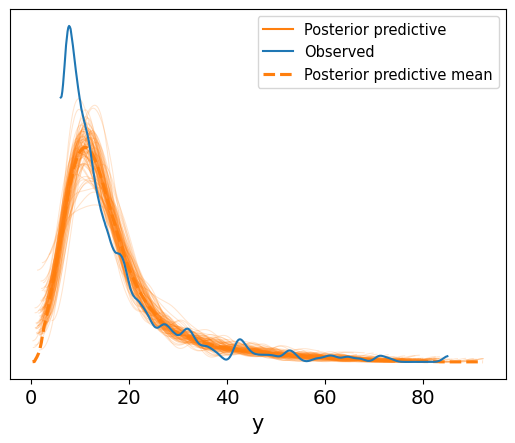

In [64]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_soccer,model_soccer, extend_inferencedata=True)
az.plot_ppc(idata_soccer, num_pp_samples=100, colors=["C1", "C0", "C1"])

So I can see that it was honestly not too far off, it predicted pretty well on the right. It actually got the steep curve on the left, just too far downwards I can't really say why exactly, because I tried different numbers for the HalfNormal (which I assumed was the problem because it makes that curve normally) and it didn't really affect much.

I'm thinking that maybe, considering how steep the incline is, that was a bit of a once in a lifetime thing, like an outlier, and the model just decided it shouldn't be accounted for.

In [48]:
posterior_mean = idata_soccer.posterior["μ"]

μ_hdi = az.hdi(ary=idata_soccer, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_soccer, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


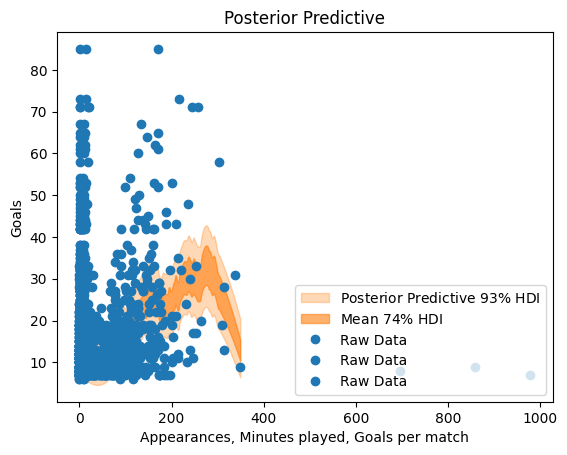

In [51]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(soccer[["Appearances", "Minutes played", "Goals per match"]], soccer["Goals"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Appearances, Minutes played, Goals per match",
    ylabel="Goals",
);

I don't particularly like the model here, because it really shows how much of the raw data I missed out on, and it makes me think I must have done something really wrong. Unless I actually just did something wrong here, in me trying to check the accuracy. Maybe I'm not supposed to put in a list like that, and it only works for single variables.

#Conclusion

Overall, my model doesn't end up being that bad, even if it could be better. I think I did have the right intuition with the predictor variables I ended up choosing, given the data I had. I think that with other data sets on soccer, I would have normally had to account for positions as I think that would play a bigger role in amount of goals scored rather than anything else. It would be interesting to try another data set on this same league, but just with player stats of a specific season.

I believe I didn't need to do this for my project because it's already filtered to just the all-time top goalscorers, so I think that would narrow it down to just the positions most likely to score. I could be wrong though, maybe I should try again. Maybe the steep incline is actually due to some abnormal instance (or player) in the data set itself and maybe it would have been better for me to check.